# Stream LLM tokens from your graph

In [1]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import add_messages

# Add messages essentially does this with more
# robust handling
# def add_messages(left: list, right: list):
#     return left + right


class State(TypedDict):
    messages: Annotated[list, add_messages]

In [29]:
# tools
from langchain_core.tools import tool


@tool
def search(query: str):
    """Call to surf the web."""
    # This is a placeholder, but don't tell the LLM that...
    return [{"content": "Cloudy with a chance of hail.", "type": "text"}]


tools = [search]

In [30]:
from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tools)

In [31]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-3.5-turbo")

In [32]:
# bind tools
model = model.bind_tools(tools)

In [33]:
# define nodes
from typing import Literal

from langchain_core.runnables import RunnableConfig

from langgraph.graph import END, START, StateGraph


# Define the function that determines whether to continue or not
def should_continue(state: State) -> Literal["__end__", "tools"]:
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return END
    # Otherwise if there is, we continue
    else:
        return "tools"


# Define the function that calls the model
async def call_model(state: State, config: RunnableConfig):
    messages = state["messages"]
    # Note: Passing the config through explicitly is required for python < 3.11
    # Since context var support wasn't added before then: https://docs.python.org/3/library/asyncio-task.html#creating-tasks
    response = await model.ainvoke(messages, config)
    # We return a list, because this will get added to the existing list
    return {"messages": response}

In [34]:
# Define a new graph
workflow = StateGraph(State)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)

workflow.add_edge("tools", "agent")

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

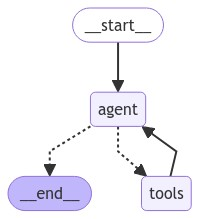

In [35]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [36]:
# Streaming LLM tokens
from langchain_core.messages import HumanMessage

inputs = [HumanMessage(content="what is the weather in sf")]
async for event in app.astream_events({"messages": inputs}, version="v1"):
    kind = event["event"]
    if kind == "on_chat_model_stream":
        content = event["data"]["chunk"].content
        if content:
            # Empty content in the context of OpenAI or Anthropic usually means
            # that the model is asking for a tool to be invoked.
            # So we only print non-empty content
            print(content, end="|")
    elif kind == "on_tool_start":
        print("--")
        print(
            f"Starting tool: {event['name']} with inputs: {event['data'].get('input')}"
        )
    elif kind == "on_tool_end":
        print(f"Done tool: {event['name']}")
        print(f"Tool output was: {event['data'].get('output')}")
        print("--")

--
Starting tool: search with inputs: {'query': 'weather in San Francisco'}
Done tool: search
Tool output was: content=[{'content': 'Cloudy with a chance of hail.', 'type': 'text'}] name='search' tool_call_id='call_qg6K6BMqxfR4mYJIXTHNo6xs'
--
The| current| weather| in| San| Francisco| is| |59|°F| with| clear| skies|.|

# Without LangChain Model
LangGraph支持使用LLM原生的接口，而不是langchain封装的model接口。这里以OpenAI为例